# Задание:
1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: [ods.ai](https://ods.ai/competitions/) и [recsyschallenge.com/2025](https://www.recsyschallenge.com/2025/) (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: [aicrowd.com](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset) и [boosters.pro](https://boosters.pro/championship/rekko_challenge/data). Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).
2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.
3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств.
4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).
5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.
# Критерии оценки:
- Разведочный анализ данных. Оценивается полнота и логика описания датасета. Полнота и логика построения отчёта, качество визуализаций. (10 баллов).
- Метод формирования рекомендаций. Оценивается полнота и логика описания выбранного метода, его обоснованность и релевантность задаче. Оценивается корректность реализации выбранного метода. (14 баллов).
- Метрики качества. Оценивается корректность выбора метрик, полнота и логика их описания, корректность реализации и интерпретации выбранных метрик. (6 баллов).


---
## 0. Импорты, скачивания

In [17]:
import implicit
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

---
## 1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: [ods.ai](https://ods.ai/competitions/) и [recsyschallenge.com/2025](https://www.recsyschallenge.com/2025/) (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: [aicrowd.com](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset) и [boosters.pro](https://boosters.pro/championship/rekko_challenge/data). Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).

За основу я взял [spotify-million-playlist-dataset-challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset).

Предобработку (json chunks в parquet) я сделал в файле [pre.py](https://github.com/HuTao1Love/DataAnalysis/blob/master/lab-2/pre.py), так как к ЛР это не относится.


In [2]:
df_full = pd.read_parquet("mpd.parquet")
df_full.head(10)

,playlist_id,playlist_name,modified_at,track_uri,track_name,artist_name,album_name,pos,duration_ms
0,0,Throwbacks,1493424000,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,0,226863
1,0,Throwbacks,1493424000,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,In The Zone,1,198800
2,0,Throwbacks,1493424000,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,Dangerously In Love (Alben für die Ewigkeit),2,235933
3,0,Throwbacks,1493424000,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,3,267266
4,0,Throwbacks,1493424000,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,Hot Shot,4,227600
5,0,Throwbacks,1493424000,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Yeah!,Usher,Confessions,5,250373
6,0,Throwbacks,1493424000,spotify:track:68vgtRHr7iZHpzGpon6Jlo,My Boo,Usher,Confessions,6,223440
7,0,Throwbacks,1493424000,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,Buttons,The Pussycat Dolls,PCD,7,225560
8,0,Throwbacks,1493424000,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Say My Name,Destiny's Child,The Writing's On The Wall,8,271333
9,0,Throwbacks,1493424000,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,Hey Ya! - Radio Mix / Club Mix,OutKast,Speakerboxxx/The Love Below,9,235213


In [3]:
playlists = df_full["playlist_id"].drop_duplicates().sample(frac=0.01, random_state=42)
df = df_full[df_full["playlist_id"].isin(playlists)].reset_index(drop=True)
df_full_len = len(df_full)
del df_full

---
## 2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.


In [4]:
print(f"Full DF size: {df_full_len:,}")
print(f"DF sample size: {len(df):,}")
print(f"Unique playlist count: {df['playlist_id'].nunique():,}")
print(f"Unique track count: {df['track_uri'].nunique():,}")
print(f"Unique artist count: {df['artist_name'].nunique():,}")
print(f"Duplicates in playlists: {df.duplicated(subset=["playlist_id", "track_uri"]).sum()}")

print("-" * 30)
print(f"Skips:\n{df.isna().sum()}")

print("-" * 30)
q_low = df["duration_ms"].quantile(0.01)
q_high = df["duration_ms"].quantile(0.99)

below = (df["duration_ms"] < q_low).sum()
above = (df["duration_ms"] > q_high).sum()

print(f"1st percentile [below - {below}]: {q_low/1000:.1f} sec")
print(f"99th percentile [above - {above}]: {q_high/1000:.1f} sec")

df.describe()

Full DF size: 66,346,428
DF sample size: 656,606
Unique playlist count: 10,000
Unique track count: 171,486
Unique artist count: 35,772
Duplicates in playlists: 8984
------------------------------
Skips:
playlist_id      0
playlist_name    0
modified_at      0
track_uri        0
track_name       0
artist_name      0
album_name       0
pos              0
duration_ms      0
dtype: int64
------------------------------
1st percentile [below - 6558]: 107.7 sec
99th percentile [above - 6562]: 467.6 sec


,playlist_id,modified_at,pos,duration_ms
count,656606.000000,6.566060e+05,656606.000000,6.566060e+05
mean,500603.565965,1.479987e+09,54.213375,2.347807e+05
std,288471.693730,3.559477e+07,48.335002,7.482561e+04
min,78.000000,1.311984e+09,0.000000,0.000000e+00
25%,252226.000000,1.465258e+09,17.000000,1.982930e+05
50%,500840.000000,1.495238e+09,40.000000,2.250140e+05
75%,753455.000000,1.506989e+09,79.000000,2.592930e+05
max,999592.000000,1.509494e+09,249.000000,9.811736e+06


In [5]:
df.sort_values(by="duration_ms", ascending=False).head(5)

,playlist_id,playlist_name,modified_at,track_uri,track_name,artist_name,album_name,pos,duration_ms
32355,141782,yasssss,1503878400,spotify:track:7ju02bkmmEBTazvhtOvURa,Asking All Dem Questions ft. Emanuel & Philip ...,The 85 South Show,Asking All Dem Questions ft. Emanuel & Philip ...,123,9811736
233190,414084,Party,1506124800,spotify:track:6jvMmRtSzoEibQGrQkSISQ,Monstercat Best of 2012,Monstercat,Monstercat - Best of 2012,45,6348017
265195,458706,Fun,1441324800,spotify:track:6jvMmRtSzoEibQGrQkSISQ,Monstercat Best of 2012,Monstercat,Monstercat - Best of 2012,10,6348017
39050,151231,My Mix,1464825600,spotify:track:3fMzqA63YYbU29Y7HOPYRC,Level up (Album Mix),Ninety9lives,Ninety9lives 97: Level Up,57,5320819
39049,151231,My Mix,1464825600,spotify:track:2zB79bs86aqT0kRTrrPO9P,Rage Quit Album Mix,Ninety9lives,Ninety9lives 98 - Rage Quit,56,4988476


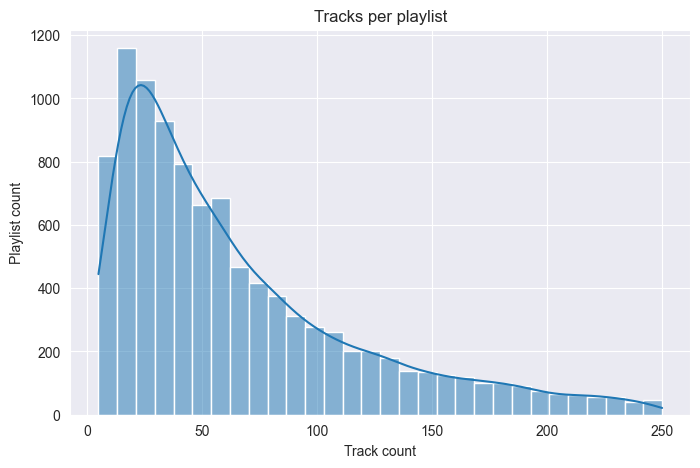

In [6]:
tracks_per_playlist = df.groupby("playlist_id")["track_uri"].count()
plt.figure(figsize=(8, 5))
sns.histplot(tracks_per_playlist, bins=30, kde=True)
plt.title("Tracks per playlist")
plt.xlabel("Track count")
plt.ylabel("Playlist count")
plt.show()

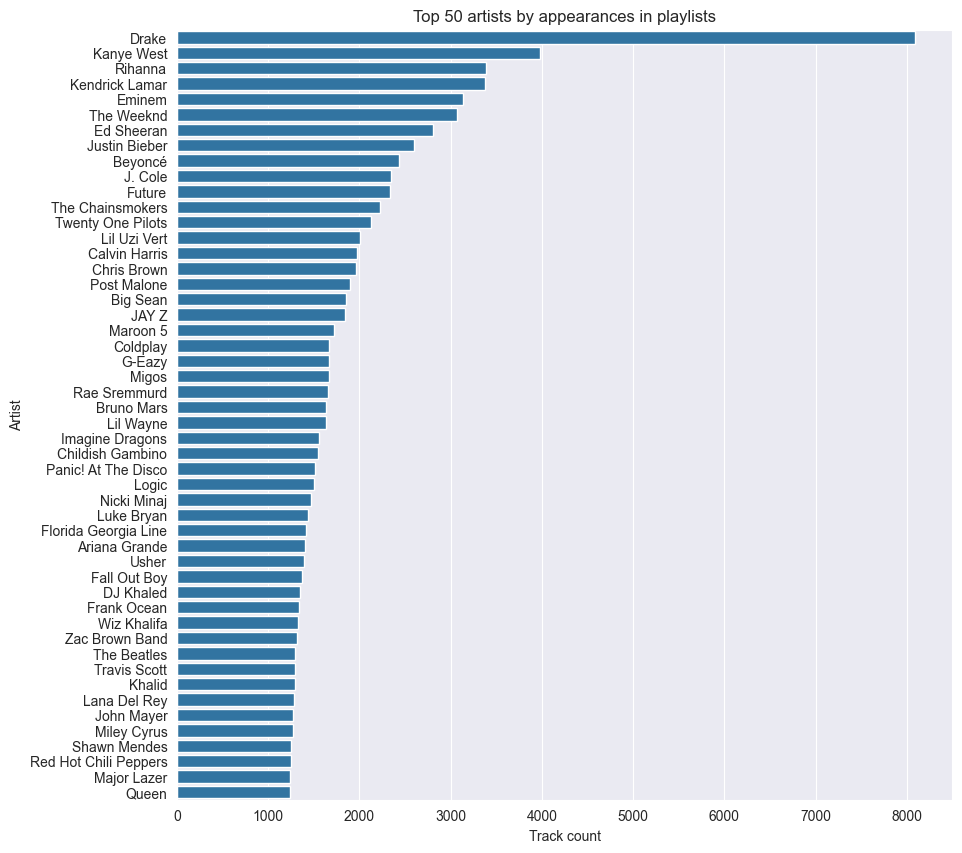

In [7]:
top_artists = df["artist_name"].value_counts().head(50)
plt.figure(figsize=(10, 10))
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title("Top 50 artists by appearances in playlists")
plt.xlabel("Track count")
plt.ylabel("Artist")
plt.show()

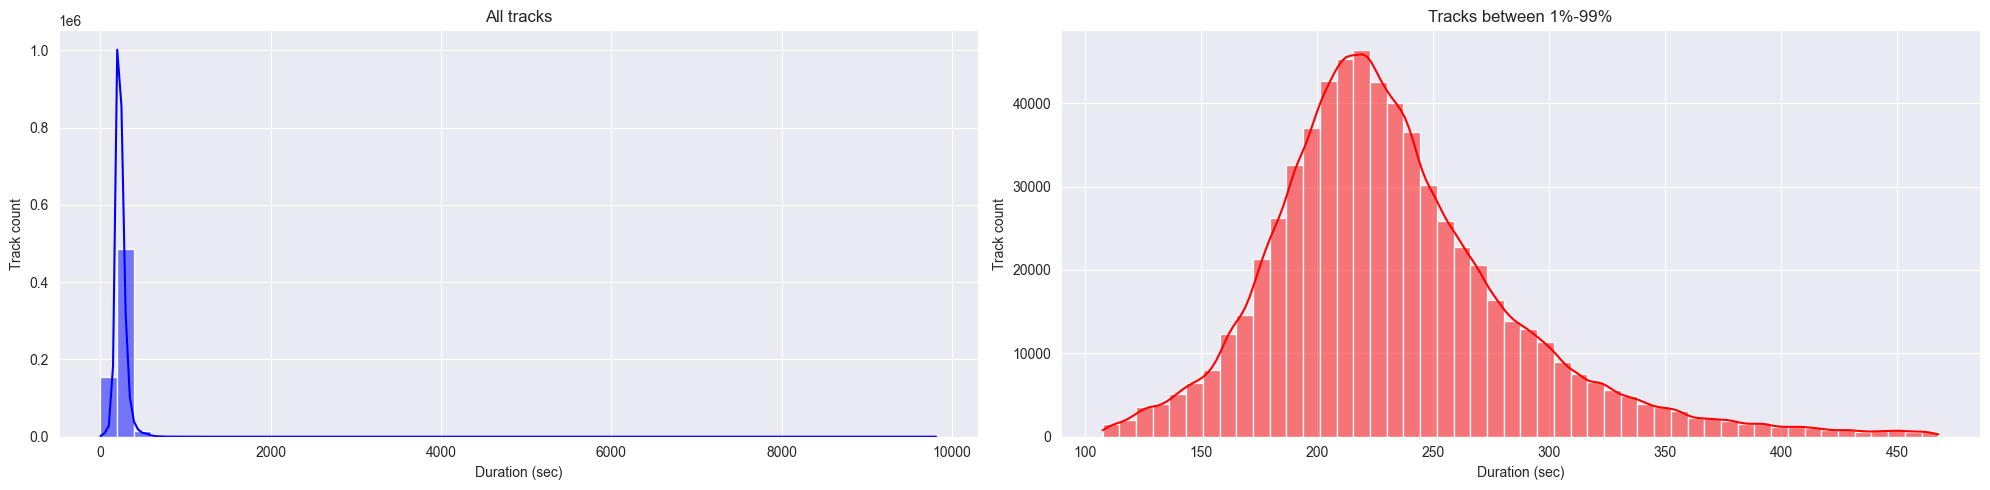

In [8]:
durations_filtered = df.loc[
    (df["duration_ms"] >= q_low) &
    (df["duration_ms"] <= q_high),
    "duration_ms"
]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df["duration_ms"] / 1000, bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("All tracks")
axes[0].set_xlabel("Duration (sec)")
axes[0].set_ylabel("Track count")

sns.histplot(durations_filtered / 1000, bins=50, kde=True, ax=axes[1], color="red")
axes[1].set_title("Tracks between 1%-99%")
axes[1].set_xlabel("Duration (sec)")
axes[1].set_ylabel("Track count")

plt.tight_layout()
plt.show()

---
## 3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств.


In [9]:
class Recommender:
    def __init__(self, rtr: csr_matrix):
        self.rtr = rtr

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        raise NotImplementedError

In [27]:
class MostPopRecommender(Recommender):
    def fit(self):
        self.track_popularity = np.asarray(self.rtr.sum(axis=0)).ravel()

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        seen = set(self.rtr[playlist_id].indices)
        rec = [i for i in np.argsort(-self.track_popularity) if i not in seen][:n]
        return np.array(rec)

In [48]:
class ItemKNNRecommender(Recommender):
    def __init__(self, rtr: csr_matrix, k_neighbors: int = 200):
        super().__init__(rtr)
        self.model = implicit.nearest_neighbours.BM25Recommender(K=k_neighbors)

    def fit(self):
        self.model.fit(self.rtr.T.astype(np.int32))

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        existing_items = self.rtr[playlist_id].indices
        recommended_items, _ = self.model.recommend(
            userid=playlist_id,
            user_items=self.rtr,
            N=n,
            filter_items=existing_items
        )
        return recommended_items

In [31]:
class ALSRecommender(Recommender):
    def __init__(self, rtr: csr_matrix, factors=64, reg=1e-3, iterations=20):
        super().__init__(rtr)
        self.model = implicit.als.AlternatingLeastSquares(
            factors=factors, regularization=reg, iterations=iterations, random_state=42
        )

    def fit(self):
        self.model.fit(self.rtr.T)

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        if self.rtr[playlist_id].nnz == 0:
            mp = MostPopRecommender(self.rtr)
            mp.fit()
            return mp.recommend(playlist_id, n)
        recs, _ = self.model.recommend(
            userid=playlist_id,
            user_items=self.rtr[playlist_id],
            N=n,
            filter_already_liked_items=True,
            recalculate_user=True
        )
        return np.array(recs)

### Пример использования

In [50]:
playlist_enc = LabelEncoder()
track_enc = LabelEncoder()

playlist_ids = playlist_enc.fit_transform(df["playlist_id"]).astype(np.int32)
track_ids = track_enc.fit_transform(df["track_uri"]).astype(np.int32)

data = np.ones(len(df), dtype=np.float32)
rtr = csr_matrix(
    (data, (playlist_ids, track_ids)),
    shape=(len(playlist_enc.classes_), len(track_enc.classes_))
)

recommenders = {
    "MostPop": MostPopRecommender(rtr),
    "ItemKNN": ItemKNNRecommender(rtr),
    "ALS": ALSRecommender(rtr),
}

for name, recommender in recommenders.items():
    recommender.fit()
    print(f"Fit for {name} completed")

playlists_with_tracks = np.where(rtr.getnnz(axis=1) > 0)[0]
probe_playlists = np.random.choice(playlists_with_tracks, size=min(5, len(playlists_with_tracks)), replace=False)
for pid in probe_playlists:
    print(f"Playlist ID: {pid}")
    print(f"Tracks in playlist: {rtr[pid].indices[:10].tolist()}")
    for name, recommender in recommenders.items():
        print(f"Recommendations for playlist by {name}:")
        print(recommender.recommend(pid))

    print()


Fit for MostPop completed


C:\Users\HuTao1Love\PycharmProjects\data-analysis\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003979921340942383 seconds
  warnings.warn(


ValueError: Buffer dtype mismatch, expected 'long' but got 'long long'

---
## 4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).


In [ ]:
class Metric:
    def __init__(self, k=10):
        self.k = k

    def compute(self, recommended, relevant):
        raise NotImplementedError


class PrecisionAtK(Metric):
    def compute(self, recommended, relevant):
        recommended = recommended[:self.k]
        relevant_set = set(relevant)
        hits = sum([1 for item in recommended if item in relevant_set])
        return hits / self.k


class NDCGAtK(Metric):
    def compute(self, recommended, relevant):
        recommended = recommended[:self.k]
        dcg = 0.0
        for i, item in enumerate(recommended):
            if item in relevant:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), self.k)))
        return dcg / idcg if idcg > 0 else 0.0


class Diversity(Metric):
    def __init__(self, item_similarity_matrix: pd.DataFrame, k=10):
        super().__init__(k)
        self.item_similarity_matrix = item_similarity_matrix

    def compute(self, recommended, relevant=None):
        recommended = recommended[:self.k]
        n = len(recommended)
        if n <= 1:
            return 0.0
        sims = []
        for i in range(n):
            for j in range(i+1, n):
                sims.append(self.item_similarity_matrix.loc[recommended[i], recommended[j]])
        return 1 - np.mean(sims)

---
## 5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.